# Footprint Pressure Heatmap (Heuristic)

입력 데이터가 단일, 분할된 RGB footprint 이미지뿐인 상황을 가정하고, 딥러닝 없이 색상·형상 단서를 이용해 압력 히트맵을 추정하는 규칙 기반 파이프라인입니다.

## 아이디어 개요

1. **입력 정리**: 세그멘테이션된 RGB에서 일정 밝기 이상을 발 영역으로 두고 마스크를 생성합니다.
2. **밝기(Intensity) 단서**: `rgb.max(axis=2)`를 기반으로 밝은 부분을 강조하고 감마를 적용해 압력과 상관있는 힌트를 얻습니다.
3. **형태(Shape) 단서**: 거리 변환으로 경계에서 멀수록 값이 커지도록 해 체중이 실릴 가능성이 큰 영역을 표현합니다.
4. **위치(Heel) 단서**: 세로 좌표 기반 편향으로 발뒤꿈치 쪽에 추가 가중치를 주어 heel 영역을 강화합니다.
5. **정규화 + 가중합**: 세 단서를 각각 [0,1]로 정규화하고 가중치를 합이 1이 되도록 맞춘 뒤 합성해 왜곡을 줄입니다.
6. **스무딩 + Jet 컬러맵**: 결과 히트맵을 부드럽게 한 뒤 jet 컬러맵으로 변환해 시각적으로 명확한 압력 분포를 얻습니다.
7. **평가/튜닝**: 정답 압력맵이 있을 경우 MAE·RMSE·상관계수·SSIM으로 검증하고, 가중치·감마를 조정해 성능을 끌어올립니다.


RGB footprint 이미지를 압력 히트맵으로 바꿀 때는 “밝기 + 형태 + 위치” 세 단서를 각각 계산한 뒤 정규화·가중합하여 jet 컬러맵으로 시각화하는 것이 핵심입니다. 이 노트북의 흐름은 다음과 같습니다.

- **발 영역만 남기기**: 세그멘테이션된 RGB에서 `mask_threshold`보다 밝은 픽셀만 1로 두고 발 모양을 확보합니다. 이후 모든 특징은 이 마스크 내부에서만 계산됩니다.

- **강도(Intensity) 단서**: `rgb.max(axis=2)`로 밝기를 얻고 감마(`intensity_gamma`)를 적용해 밝은 부분을 보다 강조합니다. 높은 압력 후보 영역이 jet 컬러맵에서 빨간·노란색으로 나타나는 기반이 됩니다.

- **형태(Shape) 단서**: 거리 변환으로 발 경계에서 멀수록 값이 커지도록 만든 뒤 `shape_gamma`로 곡선을 조정해 체중이 실릴 만한 넓은 영역을 드러냅니다.

- **위치(Heel bias)**: 세로 좌표를 이용해 발뒤꿈치 쪽에 추가 가중치를 주며, `heel_weight`와 `heel_bias_power`로 세기와 기울기를 조정합니다. 힐 영역이 jet 팔레트에서 따뜻한 색으로 강조됩니다.

- **정규화 + 가중합 + 스무딩**: 세 단서를 각각 [0, 1]로 정규화하고 가중치를 합이 1이 되도록 맞춘 뒤 합성합니다. 이후 `smooth_sigma`로 부드럽게 만들어 왜곡을 줄이고, jet 컬러맵으로 변환해 시각적으로 명확한 압력 분포를 얻습니다.

- **검증/튜닝**: 정답 압력맵이 있다면 MAE·RMSE·상관계수·SSIM을 계산해 가중치와 감마를 조정합니다. 최종 jet 히트맵과 지표를 함께 확인하면서 부족한 부분을 빠르게 개선할 수 있습니다.

이 과정을 따르면 데이터가 1개뿐이어도 각 단계를 직관적으로 조정할 수 있고, GT가 생기는 즉시 jet 컬러맵 결과와 수치 지표를 동시에 확인하며 품질을 높일 수 있습니다.

정답 압력맵(GT)은 RGB 이미지에서 바로 얻어지는 게 아니라, 별도의 압력 센서나 계측 장비를 사용해 측정해야 합니다. 일반적인 절차는 다음과 같습니다.

- 센서 매트/압력판 준비
Tekscan, XSENSOR 같은 족저압 측정 매트나 고해상도 압력판을 사용해 발이 닿는 동안의 압력을 수집합니다. 이 장비가 바로 “GT”가 될 수 있는 실제 압력 데이터를 제공합니다.

- 센서 데이터 캡처
발을 매트 위에 올리고 체중을 실을 때의 압력 분포를 측정합니다. 장비에서 보통 N/cm², kPa 등 물리 단위로 출력되며 시간 축이 있는 경우 평균이나 최대값을 선택해서 2D 맵 한 장으로 만듭니다.

- 이미지/배열 형태로 저장
측정 장비에서 제공하는 API나 소프트웨어를 통해 값을 CSV, TIFF, PNG, .npy 같은 형태로 내보냅니다. 예를 들어 .npy 배열이라면 노트북의 load_pressure_gt()가 그대로 읽을 수 있습니다.

- footprint 이미지와 정렬
RGB 발도장과 센서 좌표계를 맞춰야 합니다. 같은 해상도로 리사이즈하거나, 필요하면 기하 보정(translation/rotation/scale)을 해서 RGB와 GT가 픽셀 단위로 대응하도록 만듭니다.

- 세그멘테이션 마스크 윤곽과 센서 데이터 윤곽을 비교해 중심이나 발뒤꿈치 위치를 맞추는 방법이 일반적입니다.
정렬 후에는 최소/최대값으로 0~1 범위로 정규화합니다.

- 경로 설정
완성된 GT 파일을 예를 들어 data/padoscope/pressures/sample.npy에 저장하고, Config.pressure_gt_path를 그 경로로 맞춰 놓으면 노트북의 평가 셀에서 바로 불러와 MAE/RMSE/SSIM을 계산할 수 있습니다.

정리하자면, RGB 이미지 하나만으로는 GT를 만들 수 없고, 동일한 발/포즈를 압력 센서로 측정한 “실측 데이터”가 필요합니다. 만약 센서가 없다면, 발 전문가가 직접 압력 레벨을 주석화하거나(고정 레퍼런스), 시뮬레이션 기반 물리 모델을 돌려 근사 GT를 만드는 방법 정도가 대안입니다.

In [113]:
from pathlib import Path  # file path utilities
import numpy as np  # numeric ops
from PIL import Image  # image I/O
import matplotlib.pyplot as plt  # plotting utilities

try:  # advanced morphology & smoothing (if available)
    from scipy.ndimage import distance_transform_edt, gaussian_filter
except Exception:
    distance_transform_edt = None
    gaussian_filter = None
    print('scipy.ndimage not found → fallback smoothing used.')

try:  # SSIM metric for evaluation (optional)
    from skimage.metrics import structural_similarity as ssim_metric
except Exception:
    ssim_metric = None
    print('skimage.metrics not found → SSIM skipped.')


skimage.metrics not found → SSIM skipped.


### 구성 파라미터

In [114]:
class Config:
    rgb_path = Path('0_Original_Source.png_left_256.png')  # segmented RGB input
    pressure_gt_path = Path('data/padoscope/pressures/sample.npy')  # optional GT pressure map for eval
    mask_threshold = 10 / 255.0  # min brightness → foreground mask
    intensity_weight = 0.55  # weight for brightness cue
    shape_weight = 0.30  # weight for distance-transform cue
    heel_weight = 0.15  # weight for heel bias cue
    heel_bias_power = 1.4  # heel emphasis curve
    intensity_gamma = 0.6  # gamma correction on brightness cue
    shape_gamma = 1.2  # gamma correction on shape cue
    smooth_sigma = 2.0  # gaussian blur kernel size

cfg = Config()


### 유틸리티 함수

In [115]:
def load_segmented_rgb(path: Path):
    """Load segmented RGB image (0~1) and derive a footprint mask."""
    img = Image.open(path).convert('RGB')
    rgb = np.asarray(img, dtype=np.float32) / 255.0
    mask = (rgb.sum(axis=2) > cfg.mask_threshold).astype(np.float32)
    return rgb, mask


def compute_intensity_feature(rgb: np.ndarray, mask: np.ndarray):
    """Brightness cue: bright pixels imply higher pressure."""
    intensity = rgb.max(axis=2)
    foreground = intensity[mask > 0]
    if foreground.size:
        min_val = foreground.min()
        max_val = foreground.max()
        intensity = (intensity - min_val) / (max_val - min_val + 1e-6)
    intensity = np.clip(intensity, 0, 1) ** cfg.intensity_gamma
    return intensity * mask


def compute_shape_feature(mask: np.ndarray):
    """Shape cue: distance from boundary approximates load-bearing capacity."""
    if distance_transform_edt is not None:
        dist = distance_transform_edt(mask)
    else:
        dist = np.zeros_like(mask)
        for y in range(mask.shape[0]):
            run = 0
            for x in range(mask.shape[1]):
                run = run + 1 if mask[y, x] else 0
                dist[y, x] = max(dist[y, x], run)
    dist = dist / (dist.max() + 1e-6)
    dist = dist ** cfg.shape_gamma
    return dist * mask


def compute_heel_bias(mask: np.ndarray):
    """Heel cue: vertical coordinate bias to enhance heel region."""
    h, _ = mask.shape
    y_coords = np.linspace(1.0, 0.0, h)
    heel_profile = y_coords ** cfg.heel_bias_power
    heel_map = np.repeat(heel_profile[:, None], mask.shape[1], axis=1)
    return heel_map * mask


def smooth_heatmap(heatmap: np.ndarray):
    """Reduce noise so color transitions look natural."""
    if gaussian_filter is not None:
        return gaussian_filter(heatmap, sigma=cfg.smooth_sigma)
    kernel = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]], dtype=np.float32)
    kernel /= kernel.sum()
    padded = np.pad(heatmap, 1, mode='edge')
    out = np.zeros_like(heatmap)
    for i in range(out.shape[0]):
        for j in range(out.shape[1]):
            region = padded[i:i+3, j:j+3]
            out[i, j] = np.sum(region * kernel)
    return out


def normalize_feature_map(feature: np.ndarray) -> np.ndarray:
    """Min-max normalize any cue to [0,1] to prevent domination."""
    min_val = float(feature.min())
    max_val = float(feature.max())
    if max_val > min_val:
        feature = (feature - min_val) / (max_val - min_val)
    return np.clip(feature, 0.0, 1.0)


def blend_features(intensity: np.ndarray, shape: np.ndarray, heel: np.ndarray) -> np.ndarray:
    """Normalize cues, normalize weights, then blend to minimize distortion."""
    feats = [normalize_feature_map(intensity), normalize_feature_map(shape), normalize_feature_map(heel)]
    weights = np.array([cfg.intensity_weight, cfg.shape_weight, cfg.heel_weight], dtype=np.float32)
    weights = np.clip(weights, 1e-6, None)
    weights = weights / weights.sum()
    combined = sum(w * f for w, f in zip(weights, feats))
    return normalize_feature_map(combined)


def heatmap_to_jet(heatmap: np.ndarray) -> np.ndarray:
    """Convert normalized heatmap to an RGB jet colormap image."""
    cmap = plt.get_cmap('jet')
    return cmap(heatmap)[:, :, :3]


### 압력 히트맵 추정

In [116]:
def estimate_pressure(rgb_path: Path):
    """Generate a normalized heatmap and jet-colormap image from RGB cues."""
    rgb, mask = load_segmented_rgb(rgb_path)
    intensity = compute_intensity_feature(rgb, mask)
    shape = compute_shape_feature(mask)
    heel = compute_heel_bias(mask)

    heatmap = blend_features(intensity, shape, heel)
    heatmap = smooth_heatmap(heatmap)
    heatmap = normalize_feature_map(heatmap)
    jet_rgb = heatmap_to_jet(heatmap)
    return {
        'rgb': rgb,
        'mask': mask,
        'intensity': intensity,
        'shape': shape,
        'heel': heel,
        'heatmap': heatmap,
        'jet_rgb': jet_rgb
    }

features = estimate_pressure(cfg.rgb_path)


## 성능 평가

정답 압력 히트맵과 비교하여 MAE, RMSE, 상관계수, SSIM(가능 시)을 계산하고 차이를 시각화합니다.

In [117]:
def load_pressure_gt(path: Path, target_shape):
    """Read optional GT pressure map and resize to prediction resolution."""
    if path is None or not path.exists():
        return None
    if path.suffix.lower() == '.npy':
        arr = np.load(path)
    else:
        arr = np.array(Image.open(path).convert('F'))
    arr = arr.astype(np.float32)
    if arr.max() > arr.min():
        arr = (arr - arr.min()) / (arr.max() - arr.min())
    arr_img = Image.fromarray(arr)
    h, w = target_shape
    arr_img = arr_img.resize((w, h), Image.BILINEAR)
    return np.array(arr_img, dtype=np.float32)

def evaluate_heatmap(pred: np.ndarray, gt: np.ndarray):
    """Compute MAE, RMSE, correlation, and SSIM (if available)."""
    diff = pred - gt
    mae = float(np.mean(np.abs(diff)))
    rmse = float(np.sqrt(np.mean(diff ** 2)))
    corr = float(np.corrcoef(pred.flatten(), gt.flatten())[0, 1])
    ssim_val = None
    if ssim_metric is not None:
        ssim_val = float(ssim_metric(gt, pred, data_range=1.0))
    return {'MAE': mae, 'RMSE': rmse, 'Corr': corr, 'SSIM': ssim_val}

def plot_comparison(pred: np.ndarray, gt: np.ndarray):
    """Visual side-by-side comparison plus difference heatmap."""
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(pred, cmap='jet'); axes[0].set_title('Predicted')
    axes[1].imshow(gt, cmap='jet'); axes[1].set_title('Ground Truth')
    axes[2].imshow(pred - gt, cmap='bwr'); axes[2].set_title('Difference')
    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

gt_pressure = load_pressure_gt(cfg.pressure_gt_path, features['heatmap'].shape)
if gt_pressure is None:
    print('정답 압력맵 경로가 없거나 읽을 수 없어 성능 평가를 건너뜁니다.')
else:
    metrics = evaluate_heatmap(features['heatmap'], gt_pressure)
    print('평가 지표:')
    for k, v in metrics.items():
        if v is None:
            print(f'{k}: N/A (라이브러리 없음)')
        else:
            print(f'{k}: {v:.4f}')
    plot_comparison(features['heatmap'], gt_pressure)


정답 압력맵 경로가 없거나 읽을 수 없어 성능 평가를 건너뜁니다.


### 시각화

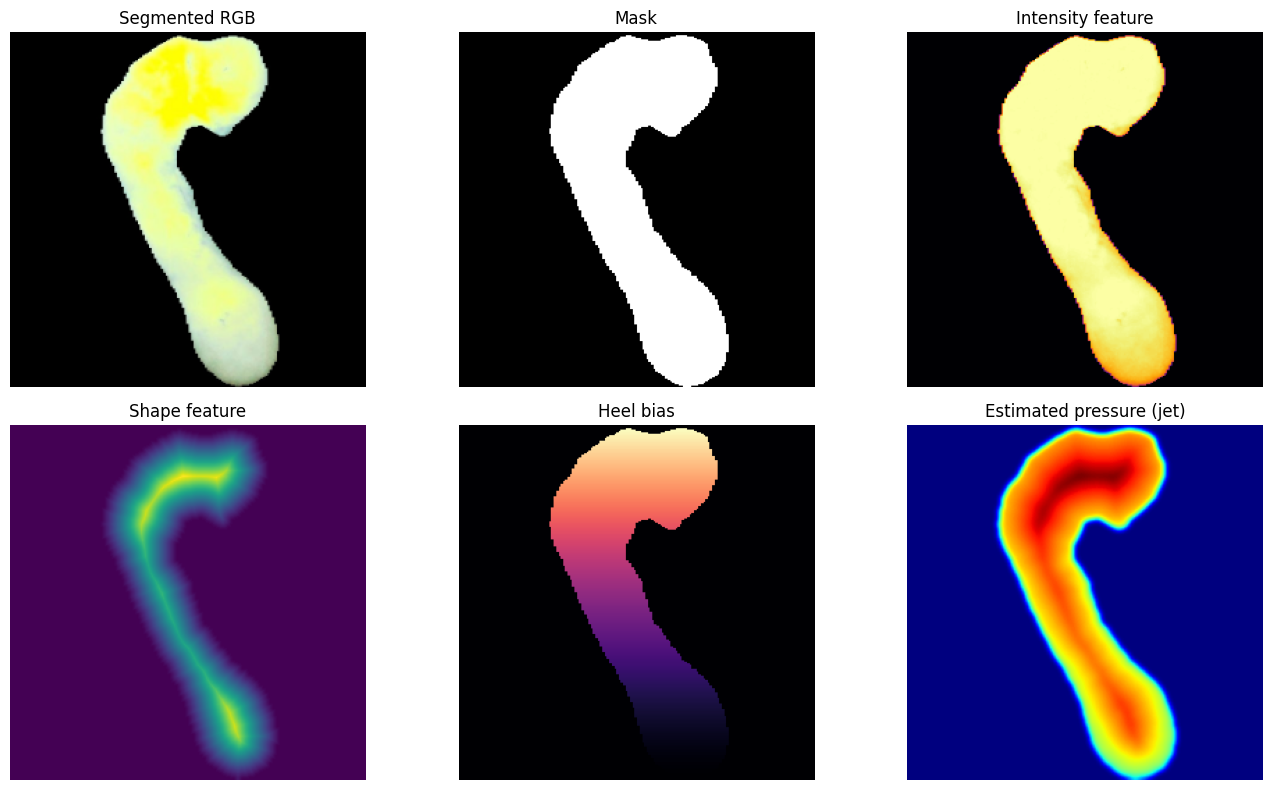

In [118]:
def plot_features(feat: dict):
    """Review each cue plus the final jet heatmap to guide tuning."""
    fig, axes = plt.subplots(2, 3, figsize=(14, 8))
    axes = axes.ravel()
    axes[0].imshow(feat['rgb']); axes[0].set_title('Segmented RGB')
    axes[1].imshow(feat['mask'], cmap='gray'); axes[1].set_title('Mask')
    axes[2].imshow(normalize_feature_map(feat['intensity']), cmap='inferno'); axes[2].set_title('Intensity feature')
    axes[3].imshow(normalize_feature_map(feat['shape']), cmap='viridis'); axes[3].set_title('Shape feature')
    axes[4].imshow(normalize_feature_map(feat['heel']), cmap='magma'); axes[4].set_title('Heel bias')
    axes[5].imshow(feat['jet_rgb']); axes[5].set_title('Estimated pressure (jet)')
    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_features(features)


### 히트맵 저장 (선택)

In [119]:
def save_heatmap(feat: dict, out_path: Path):
    """Persist the jet-colored heatmap as an RGB image."""
    cmap_img = (feat['jet_rgb'] * 255).astype(np.uint8)
    Image.fromarray(cmap_img).save(out_path)
    print(f'Saved to {out_path}')

# save_heatmap(features, Path('output/pressure_estimate.png'))


In [120]:
def print_pressure_grid(feat: dict, grid_size: int = 16):
    """Downsample the normalized heatmap to a grid and print values for quick inspection."""
    heat = feat['heatmap']
    h, w = heat.shape
    gh = grid_size
    gw = grid_size
    block_h = h // gh if h >= gh else 1
    block_w = w // gw if w >= gw else 1
    grid = []
    for r in range(gh):
        row_vals = []
        for c in range(gw):
            block = heat[r*block_h:(r+1)*block_h, c*block_w:(c+1)*block_w]
            row_vals.append(float(block.mean()) if block.size else 0.0)
        grid.append(row_vals)
    print(f'Pressure grid ({gh}x{gw}):')
    for row in grid:
        print(' '.join(f'{v:0.2f}' for v in row))
    return grid

# 예시 실행
print_pressure_grid(features)


Pressure grid (16x16):
0.00 0.00 0.00 0.00 0.00 0.00 0.20 0.54 0.46 0.54 0.52 0.07 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.35 0.78 0.87 0.87 0.88 0.83 0.33 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.16 0.74 0.90 0.96 0.95 0.94 0.83 0.35 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.53 0.85 0.93 0.84 0.80 0.81 0.62 0.07 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.01 0.62 0.87 0.87 0.67 0.24 0.43 0.07 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.45 0.81 0.81 0.39 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.13 0.72 0.79 0.53 0.02 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.51 0.79 0.72 0.18 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.22 0.73 0.77 0.39 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.02 0.55 0.76 0.66 0.14 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.19 0.68 0.75 0.56 0.08 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.43 0.74 0.74 0.56 0.09 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.

[[0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0023356627722625014,
  0.19972173101895482,
  0.5434049492853623,
  0.45743026415564053,
  0.5361670338918021,
  0.5236956616666584,
  0.06809055033401677,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0007678163016608756,
  0.3497525528319285,
  0.7834008594192827,
  0.871382906688027,
  0.8699785733998671,
  0.8799848492475913,
  0.8304670272970712,
  0.33146824741490455,
  5.261343101024322e-06,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  0.0,
  1.3895082091819395e-06,
  0.15837730578467737,
  0.7422206984575054,
  0.8992422906520627,
  0.9642297395459973,
  0.9508824886448208,
  0.9425534774141998,
  0.8258829087470008,
  0.354482530437756,
  6.936207972747135e-06,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  0.0,
  0.0013679994874579895,
  0.5280198172539267,
  0.8454063978896221,
  0.9258393934137931,
  0.842090521639181,
  0.7977072182412339,
  0.8113273760615334,
  0.6180633768455344,
  0.06610260413040428,
  0.0,
  0.0,
  0.0,
  0.0],
 

### 그리드 오버레이 시각화
격자별 평균 압력을 jet 히트맵 위에 텍스트로 표시해 왜곡 여부를 직관적으로 확인합니다.

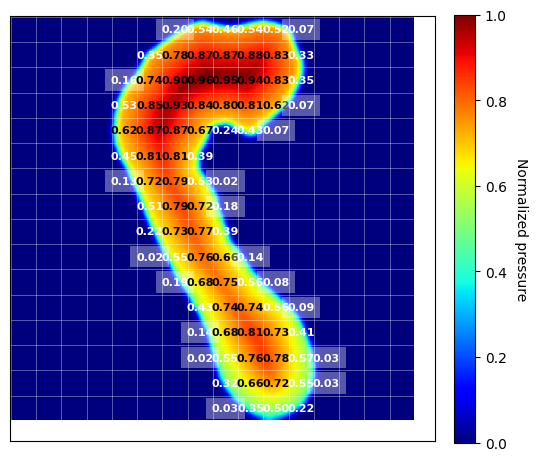

In [121]:
def show_heatmap_with_grid(feat: dict, grid_size: int = 16):
    heat = feat['heatmap']
    mask = feat['mask']
    h, w = heat.shape
    gh = grid_size
    gw = grid_size
    block_h = h // gh if h >= gh else 1
    block_w = w // gw if w >= gw else 1
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(heat, cmap='jet', vmin=0.0, vmax=1.0)  # draw scalar heatmap so colorbar matches
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Normalized pressure', rotation=270, labelpad=15)
    for r in range(gh):
        for c in range(gw):
            y0, y1 = r*block_h, min((r+1)*block_h, h)
            x0, x1 = c*block_w, min((c+1)*block_w, w)
            block = heat[y0:y1, x0:x1]
            block_mask = mask[y0:y1, x0:x1]
            if block.size == 0 or np.sum(block_mask) == 0:
                continue
            val = float(block.mean())
            y = y0 + (y1 - y0) / 2
            x = x0 + (x1 - x0) / 2
            txt_color = 'black' if val > 0.6 else 'white'
            bbox = dict(facecolor='white', alpha=0.35, edgecolor='none') if val <= 0.2 else None
            ax.text(x, y, f'{val:0.2f}', color=txt_color, ha='center', va='center', fontsize=8, weight='bold', bbox=bbox)
    for r in range(gh + 1):
        ax.axhline(min(r * block_h, h), color='white', linewidth=0.5, alpha=0.5)
    for c in range(gw + 1):
        ax.axvline(min(c * block_w, w), color='white', linewidth=0.5, alpha=0.5)
    ax.set_xticks([]); ax.set_yticks([])
    plt.show()

# 예시 실행
show_heatmap_with_grid(features)


필요 시 `Config`의 가중치·감마·발뒤꿈치 편향을 조정하며 목표 압력 분포에 맞추세요.

#### RGB 한 장만으로 압력 히트맵을 만들 때 생기는 편향을 줄이려면 “단서 자체를 최대한 균형 있게 만들고, 정답 데이터로 주기적으로 보정한다”는 두 축이 필요합니다.

1. 특징 정규화 + 가중치 재조정

- 밝기, 형태, heel 편향을 각각 [0,1]로 정규화하고 가중치를 합이 1이 되도록 조절하면 어느 한 단서가 과도하게 지배하는 것을 막을 수 있습니다.
- 현재 노트북의 blend_features()처럼 cue별 정규화 → weight-normalization → 합성 과정을 두면, RGB 밝기가 특이하게 강한 이미지여도 전체 스케일이 틀어지는 일이 줄어듭니다.

2. 스무딩(Smoothing)과 마스크 기반 필터링 기법법

- smooth_sigma로 부드럽게 한 뒤 마스크 바깥 영역은 0으로 유지하면, 히트맵이 발 내부에서만 변화하므로 주변 노이즈로 인한 편향이 줄어듭니다.

3. 실측 압력 데이터로 튜닝

- 결국 “최선”은 주기적으로 정답 압력맵과 비교해 MAE·RMSE·상관계수·SSIM을 계산하고 가중치·감마를 조정하는 것입니다. 노트북에 있는 평가 셀을 활용해 GT와 차이를 눈으로 확인하면서 intensity_weight나 shape_gamma 등을 바꾸면, 특정 구역에서 과소/과대 예측되는 편향을 줄일 수 있습니다.
- GT가 충분히 모이면 자동으로 grid-search/최적화를 돌려 가장 낮은 오류를 주는 파라미터를 찾는 것도 좋은 방법입니다.

4. 추가 단서 확보

- 가능하다면 발의 실제 압력을 측정한 센서 데이터나, 다중 각도 촬영·깊이 정보 같은 추가 입력을 마련하면 편향을 더 근본적으로 줄일 수 있습니다.
정리하면, 지금처럼 cue를 별도로 정규화하고 가중치 합을 1로 맞춘 뒤, GT와 비교해 꾸준히 재조정하는 것이 가장 현실적인 방법입니다. GT가 없으면 시각화로 직관적으로 튜닝하고, GT가 생기면 즉시 평가 셀을 통해 편향 정도를 수치로 확인해 개선하세요.